## Getting Data

### Data Source
[Movie Lens 100K](https://grouplens.org/datasets/movielens/100k/): [description](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt)

### Data Preliminary

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

In [4]:
fname = 'data/ml-100k/u.data'
data = pd.read_csv( fname, sep= '\t', 
                   header = 0,
                   names = ['user_id', 'item_id', 'rating', 'timestamp']
                  )

In [5]:
data.head()

,user_id,item_id,rating,timestamp
0,186,302,3,891717742
1,22,377,1,878887116
2,244,51,2,880606923
3,166,346,1,886397596
4,298,474,4,884182806


In [6]:
data.dtypes

user_id      int64
item_id      int64
rating       int64
timestamp    int64
dtype: object

#### Checking for Missing and Dup data

Text(176,0.5,'missing data')

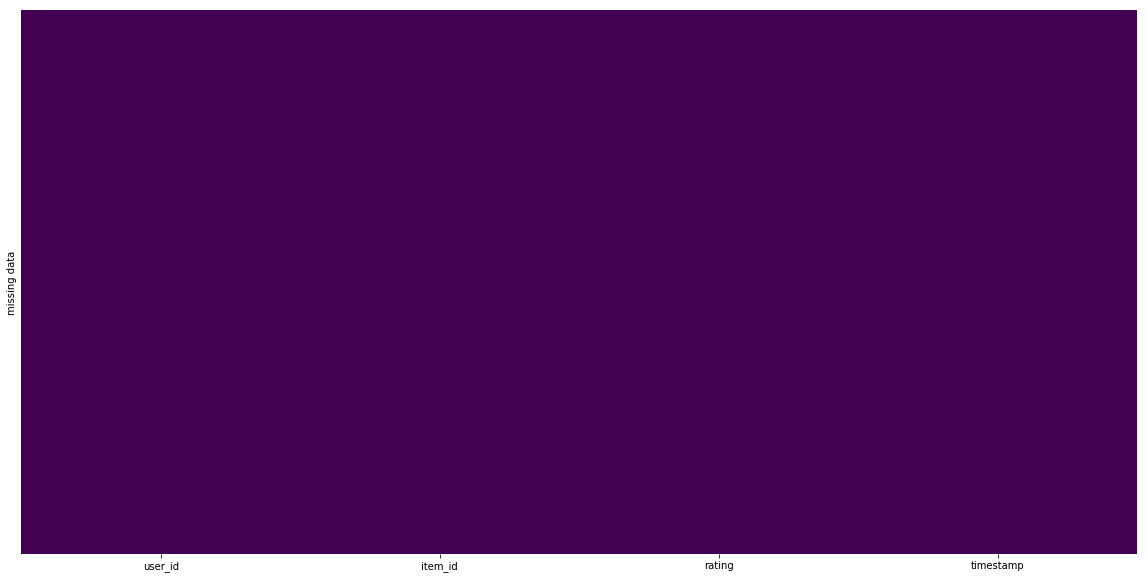

In [9]:
plt.figure(figsize = (20,10))
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.ylabel('missing data')

In [10]:
# Enter the combo of columns that should be unique here:
l_dup_check = ['user_id',
               'item_id',
               'rating'
              ]

data_dup = data[
            data.duplicated( 
                subset = l_dup_check, 
                keep = False)
            ]
print( f' Found { len ( data_dup )} duplicated records.')

if len(data_dup)> 0:
    data_dup.head(10)

 Found 0 duplicated records.


In [12]:
u_users = data.user_id.unique()
u_movies = data.item_id.unique()

print(f'There are {len(u_users)} users.')
print(f'There are {len(u_movies)} movies.')

There are 943 users.
There are 1682 movies.


#### Grouping and Summarizing
* some [references here](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)
* get **User Rating Count Distribution**
* get **Movie Rating Count Distribution**

In [25]:
agg_user = data.groupby(['user_id']).agg({
        'item_id': {'movie_count':'count'},
        'rating': {'avg_rating': 'mean'}
    })
agg_movie = data.groupby(['item_id']).agg({
        'user_id': {'user_count':'count'},
        'rating': {'avg_rating': 'mean'}
    })

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,"User's Review Count Distribution")

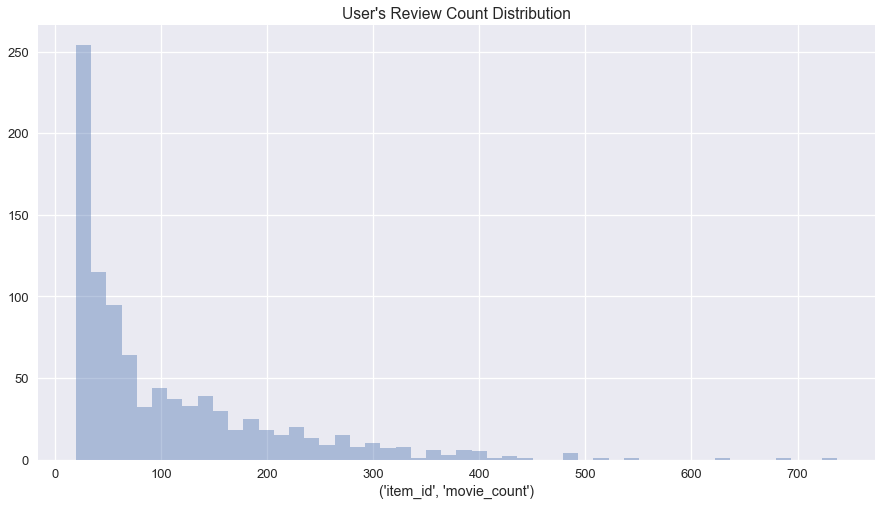

In [28]:
plt.figure( figsize = (15, 8))
sns.set(style = 'darkgrid', context = 'talk')
g = sns.distplot( 
            agg_user[('item_id','movie_count')],
            kde = False, bins = 50
        )
g.set_title("User's Review Count Distribution")

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,"Movie's Reviews Count Distribution")

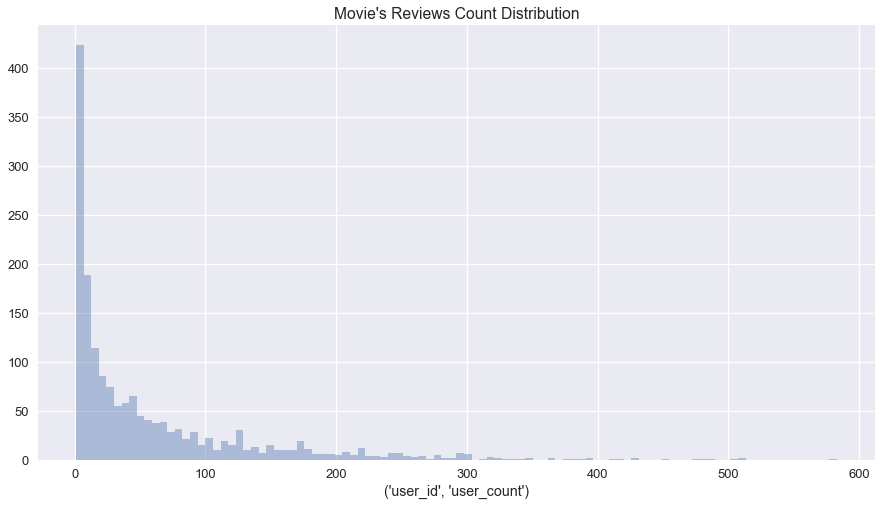

In [38]:
plt.figure( figsize = (15, 8))
sns.set(style = 'darkgrid', context = 'talk')
g = sns.distplot( 
            agg_movie[('user_id','user_count')],
            kde = False, bins = 100
        )
g.set_title("Movie's Reviews Count Distribution")

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,"Movie's Rating Distribution")

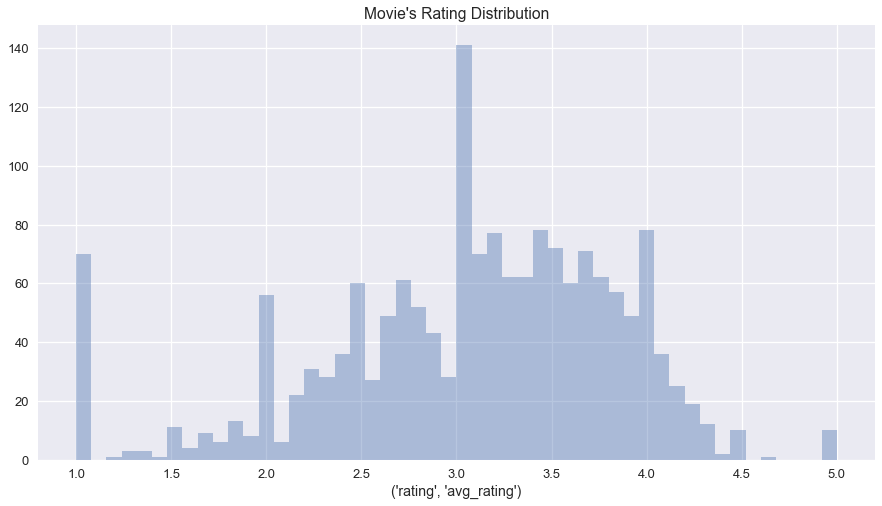

In [30]:
plt.figure( figsize = (15, 8))
sns.set(style = 'darkgrid', context = 'talk')
g = sns.distplot( 
            agg_movie[('rating','avg_rating')],
            kde = False, bins = 50
        )
g.set_title("Movie's Rating Distribution")

#### Seems like we should cut out movies with less than 50 reviews
note that from the dataset, all users have at least 20 views

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,"Movie's Reviews Count Distribution with cutoff at 10 reviews")

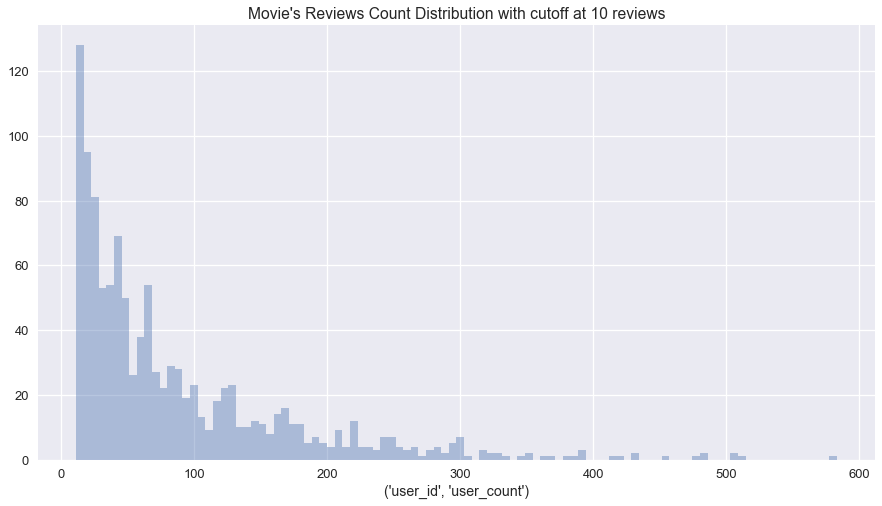

In [53]:
n_count = 10
plt.figure( figsize = (15, 8))
sns.set(style = 'darkgrid', context = 'talk')
g = sns.distplot( 
            agg_movie[agg_movie['user_id', 'user_count'] > n_count][('user_id','user_count')],
            kde = False, bins = 100
        )
g.set_title(f"Movie's Reviews Count Distribution with cutoff at {n_count} reviews")


## Transpose Data into Matrix

on how to index user_id from a multiindex column, check [here](https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html)

In [55]:
n_count = 50
filtered_item_id = agg_movie[agg_movie['user_id', 'user_count'] > n_count].index

In [74]:
data['keep_item'] = data.item_id.apply( lambda x: x in list(filtered_item_id))
raw = data[data.keep_item == True].loc[:,['user_id','item_id','rating']]

In [73]:
ui_matrix = pd.pivot_table( raw,
                          values = 'rating',
                          index = 'user_id',
                            columns= ['item_id']
                          )
print(f'Filtered Dataset is of the shape (# of User, # of Movies): {ui_matrix.shape}')

Filtered Dataset is of the shape (# of User, # of Movies): (943, 593)


## Finding Distance between Users

#### Let's get two random users

In [92]:
random = ui_matrix.sample(2, random_state = 420).index.values
user1, user2 = tuple(random)
print(f'User1 id: {user1} and User2 id:{user2}')

User1 id: 444 and User2 id:330


#### We will use hamming distance
* [reference from scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.hamming.html#scipy.spatial.distance.hamming) and math expression is [this](https://en.wikipedia.org/wiki/Distance_correlation#Distance_correlation)

In [97]:
from scipy.spatial.distance import hamming

def ham_distance( userid_1, userid_2, user_item_matrix):
    try:
        u1 = user_item_matrix[ui_matrix.index == userid_1]
        u2 = user_item_matrix[ui_matrix.index == userid_2]
        distance = hamming( u1, u2)
    except:
        distance = np.NAN
    return distance

In [98]:
ham_distance(user1, user2, ui_matrix)

0.9983136593591906

In [126]:
def GetNeighbors(ui_mat, user_id, knearest = 10):
    df_all = pd.DataFrame(ui_mat.index)
    df_all = df_all[df_all.user_id != user_id]
    df_all['distance'] = df_all.user_id.apply( lambda x : ham_distance(user_id, x, ui_mat))
    
    # ascending = True because hamming distance represent the percentage of the array U, V
    #   that is different; therefore, smaller hamming distance means more similar arrays
    neighbors = df_all.sort_values(['distance'], ascending=True) 
    return neighbors[: min(knearest, len(neighbors))]

In [127]:
GetNeighbors( ui_matrix, user1)

,user_id,distance
343,344,0.984823
623,624,0.984823
485,486,0.986509
25,26,0.986509
333,334,0.986509
275,276,0.986509
675,676,0.986509
454,455,0.988196
893,894,0.988196
415,416,0.988196


In [138]:
def GetItemSuggest(ui_mat, user_id, N = 5):
    neighbors_id = GetNeighbors(ui_mat, user_id, 10)['user_id']
    neighbors_data = ui_mat[ui_mat.index.isin(list(neighbors_id)) ]
    neighbors_items_rating = neighbors_data.apply( np.nanmean )
    
    OldItems = ui_mat.T[user_id].dropna().index
    NewItems = neighbors_items_rating[~ neighbors_items_rating.index.isin(list(OldItems))]
    NewItems_sorted = NewItems.sort_values(ascending = False).index   #<- comment out .index to see the avgRating
    
    return list(NewItems_sorted[ : min(N, len(NewItems_sorted))])
    

In [139]:
GetItemSuggest( ui_matrix, user1, 10)

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/pandas/core/apply.py:242: RuntimeWarning: Mean of empty slice
  labels=labels)


[1119, 880, 194, 195, 873, 199, 699, 201, 208, 211]

#### Get Data about Items and Movies

In [153]:
fname = 'data/ml-100k/u.item'
idata = pd.read_csv( fname, sep= '\t', 
                   header = 0,
                   names = [
                       'movie id','movie title','release date','video release date',
                       'IMDb URL','unknown','Action','Adventure','Animation',"Children's",
                       'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror',
                       'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'],
                    encoding = 'iso-8859-1'
                  )

ParserError: Too many columns specified: expected 24 and found 1

In [143]:
idata.head()

,1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
0,2|GoldenEye (1995)|01-Jan-1995||http://us.imdb...
1,3|Four Rooms (1995)|01-Jan-1995||http://us.imd...
2,4|Get Shorty (1995)|01-Jan-1995||http://us.imd...
3,5|Copycat (1995)|01-Jan-1995||http://us.imdb.c...
4,6|Shanghai Triad (Yao a yao yao dao waipo qiao...


In [148]:
s = '''movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |'''
ls = s.split('|')
lls = [ s.strip() for s in ls]

In [152]:
"','".join(lls)

"movie id','movie title','release date','video release date','IMDb URL','unknown','Action','Adventure','Animation','Children's','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','"